In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product, combinations
import matplotlib.pyplot as plt

from voting.profile_optimized import *

#import voting methods
from voting.voting_methods_for_optimized import *
from voting.voting_methods_split_cycle import *

# tools to generate profiles
from generate_profiles import *
import multiprocessing as mp
import cPickle as pickle
# display winners of a voting method
def display_winners(vm, prof):
    print  "{} winners: {}".format(vm.__doc__, "{" + ", ".join([prof.cname(_) for _ in vm(prof)]) + "}")


In [3]:
def find_winners_double_ref(vs, vms = [splitcycle_faster, beatpath_faster]):
    
    # generate a profile
    num_voters = vs[0]
    num_cands = vs[1]
    phi=vs[2]
    
    cand_names, voter_names = generate_names_opt(num_cands, num_voters)

    cmap = generate_candidate_maps(cand_names)

    num_cands = len(cand_names)
    num_voters = len(voter_names)

    _prof = create_prof_opt_mallows_two_rankings(num_voters, cmap, phi)
    prof = ProfileOpt(_prof, cand_names, voter_names) 

    return [vm(prof) for vm in vms]

def find_winners_single_ref(vs, vms = [splitcycle_faster, beatpath_faster]):
    
    # generate a profile
    num_voters = vs[0]
    num_cands = vs[1]
    phi=vs[2]
    
    cand_names, voter_names = generate_names_opt(num_cands, num_voters)

    cmap = generate_candidate_maps(cand_names)

    num_cands = len(cand_names)
    num_voters = len(voter_names)

    _prof = create_prof_opt_mallows(num_voters, cmap, phi)
    prof = ProfileOpt(_prof, cand_names, voter_names) 

    return [vm(prof) for vm in vms]


In [4]:
## Warning: this takes a very long time to run! 
#
num_profiles = 10000 #000

number_of_voters = [5, 9, 25, 55, 101, 501, 1001, 5001] #, 101, 1001]

number_of_cands = [5, 7, 10, 20, 30]  

prob_models = {'Impartial Culture': (find_winners_single_ref, 1.0),
               'Mallows-0.8': (find_winners_single_ref, 0.8),
               'Mallows-0.8, 2 Refs': (find_winners_double_ref, 0.8)}

voting_situations = list(itertools.product(number_of_voters, number_of_cands))

num_diff  = {"Impartial Culture": {vs: 0 for vs in voting_situations},
             "Mallows-0.8": {vs: 0 for vs in voting_situations},
             "Mallows-0.8, 2 Refs": {vs: 0 for vs in voting_situations}}

pool = mp.Pool(mp.cpu_count())

print mp.cpu_count()

for pm in prob_models.keys():
    print "\n"
    print pm
    for vs in voting_situations:
        print "\nvoters: {}, cands: {}".format(vs[0], vs[1])
        num_voters = vs[0]
        num_cands = vs[1]
        all_winners = pool.map(prob_models[pm][0],[(num_voters, num_cands, prob_models[pm][1]) for _ in range(num_profiles)])
        print "done calculating winners"
        for ws in all_winners:
            sc_winners, beatpath_winners  = ws
            if sc_winners != beatpath_winners:
                num_diff[pm][vs] += 1
                
print("done.")
pickle.dump(num_diff, open("num_diffs.pkl","wb"))
print num_diff

8


Mallows-0.8, 2 Refs

voters: 5, cands: 5
done calculating winners

voters: 5, cands: 7
done calculating winners

voters: 5, cands: 10
done calculating winners

voters: 5, cands: 20
done calculating winners

voters: 5, cands: 30
done calculating winners

voters: 9, cands: 5
done calculating winners

voters: 9, cands: 7
done calculating winners

voters: 9, cands: 10
done calculating winners

voters: 9, cands: 20
done calculating winners

voters: 9, cands: 30
done calculating winners

voters: 25, cands: 5
done calculating winners

voters: 25, cands: 7
done calculating winners

voters: 25, cands: 10
done calculating winners

voters: 25, cands: 20
done calculating winners

voters: 25, cands: 30
done calculating winners

voters: 55, cands: 5
done calculating winners

voters: 55, cands: 7
done calculating winners

voters: 55, cands: 10
done calculating winners

voters: 55, cands: 20
done calculating winners

voters: 55, cands: 30
done calculating winners

voters: 101, cands: 5
done calcul

In [4]:
## uncomment to load from the pickle file
#num_diff = pickle.load(open('num_diffs.pkl', "r"))

['5', '9', '25', '55', '101', '501', '1001', '5001']


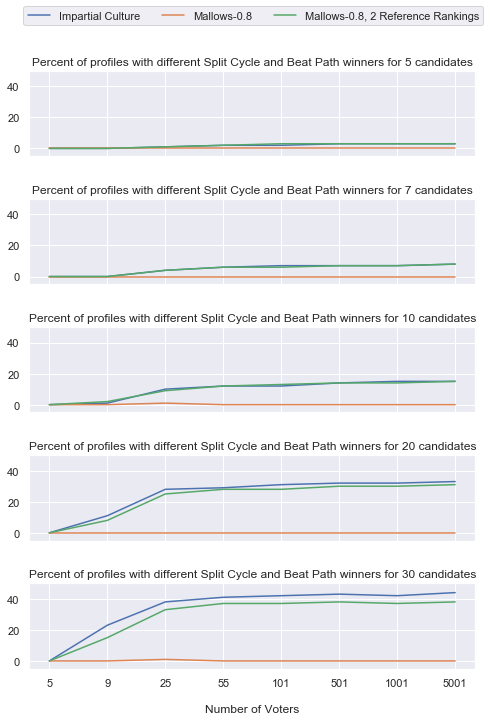

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()

num_profiles=10000
current_palette = sns.color_palette()


##sc_color = current_palette[0]
#bp_color = current_palette[1]
##smith_color = current_palette[2]

number_of_voters = [5, 9, 25, 55, 101, 501, 1001, 5001] #, 101, 1001]

number_of_cands = [5, 7, 10, 20, 30]  


fig, axs = plt.subplots(len(number_of_cands), 1, sharex=True,figsize=(8,11))
xs = [str(_) for _ in number_of_voters]

print xs
for idx,num_cands in enumerate(number_of_cands): 
    axs[idx].plot(xs, 
                [round(float(num_diff["Impartial Culture"][(num_voters, num_cands)]) / num_profiles, 2) *100 for num_voters in number_of_voters], 
                  label="Impartial Culture")
    axs[idx].plot(xs, [round(float(num_diff["Mallows-0.8"][(num_voters, num_cands)]) / num_profiles,2) *100 for num_voters in number_of_voters],
                label="Mallows-0.8")
    axs[idx].plot(xs, [round(float(num_diff["Mallows-0.8, 2 Refs"][(num_voters, num_cands)]) / num_profiles,2) *100 for num_voters in number_of_voters],
                  label="Mallows-0.8, 2 Reference Rankings")

 ##   axs[idx].plot(xs, [round(float(num_mult_winners["nanson"][(num_voters, num_cands)][phi]) / num_profiles,2) *100 for num_voters in number_of_voters],
 #                label="Nanson")
#
    axs[idx].set_title("Percent of profiles with different Split Cycle and Beat Path winners for {} candidates".format(num_cands))
    axs[idx].set_ylim(-5,50)
    
axs[idx].set_xlabel("\nNumber of Voters")
#plt.legend(loc='upper right')
plt.legend(bbox_to_anchor=(-0.025, 7.47, 1., .102), loc='lower left',
           ncol=3, )
plt.subplots_adjust(hspace=0.5)
#plt.tight_layout()
plt.savefig("percent_diff_bp_sc_winners")
